# 04 — Satellite Parking Lot Fill Index (Inventory Proxy)

## Idea
Tesla stores finished vehicles in **large open-air parking lots** adjacent to its factories before shipping them to customers. A fuller lot suggests **higher inventory** — potentially a signal of:
- Strong production (bullish if demand matches)
- Oversupply / slow deliveries (bearish pressure on earnings)

We use **Sentinel-2 satellite imagery** (free, 10m resolution, ~5-day revisit) to build a simple **brightness-based fill index**:
- **Cars are shiny/reflective** → parking lots appear brighter in visible bands when full
- **Empty asphalt is dark grey** → lower mean reflectance

This gives us a monthly time series we can later correlate with TSLA price movements, especially around earnings/delivery reports.

## Data Source
- **COPERNICUS/S2_SR_HARMONIZED** — Sentinel-2 Surface Reflectance, atmospherically corrected
- Bands: B2 (Blue, 10m), B3 (Green, 10m), B4 (Red, 10m)

## Prerequisites
```bash
pip install earthengine-api
earthengine authenticate   # run once in terminal
```
You also need a [Google Earth Engine project](https://code.earthengine.google.com/) — the free tier is sufficient.

In [33]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

# Fix SSL certs for macOS Python 3.13 in venvs
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

import warnings
warnings.filterwarnings('ignore')

## 1. Authenticate & Initialize GEE

Run `ee.Authenticate()` once (it opens a browser). After that, only `ee.Initialize()` is needed.

In [34]:
# Uncomment the line below the FIRST time you run this notebook:
# ee.Authenticate()

ee.Initialize(project='tsla-satellite')
print('GEE initialized.')

GEE initialized.


## 2. Define Parking Lot Polygons

We define rectangular/polygonal regions over the main vehicle storage lots at each factory.

**How to refine these:**
1. Open [Google Maps](https://maps.google.com) or [Google Earth](https://earth.google.com)
2. Navigate to the factory, find the large open parking areas full of cars
3. Right-click corners → "What's here?" → copy lat/lon
4. Replace the coordinates below

Coordinates are `[longitude, latitude]` (GEE convention).

In [ ]:
# ── Giga Texas (Austin, TX) ──────────────────────────────────────────
# Kept: north (best signal), west (good variation)
# Dropped: west_small (always full, no variation), east (vegetation contamination)

GIGA_TX_NORTH = ee.Geometry.Polygon([[
    [-97.61934, 30.22773],
    [-97.61807, 30.22773],
    [-97.61807, 30.22699],
    [-97.61934, 30.22699],
]])

GIGA_TX_WEST = ee.Geometry.Polygon([[
    [-97.61524, 30.22736],
    [-97.61267, 30.22736],
    [-97.61267, 30.22283],
    [-97.61579, 30.22302],
]])

# ── Fremont Factory (Fremont, CA) ────────────────────────────────────
# Kept: 1, 2, 3, 5, 6, 8 (all show meaningful variation)
# Dropped: 4 (always empty), 7 (always empty — wrong polygon)

FREMONT_1 = ee.Geometry.Polygon([[
    [-121.94770, 37.49557],
    [-121.94624, 37.49586],
    [-121.94532, 37.49419],
    [-121.94713, 37.49369],
]])

FREMONT_2 = ee.Geometry.Polygon([[
    [-121.94723, 37.49374],
    [-121.94616, 37.49418],
    [-121.94543, 37.49272],
    [-121.94648, 37.49247],
]])

FREMONT_3 = ee.Geometry.Polygon([[
    [-121.94623, 37.49226],
    [-121.94454, 37.49280],
    [-121.94286, 37.48938],
]])

FREMONT_5 = ee.Geometry.Polygon([[
    [-121.94131, 37.48852],
    [-121.93727, 37.48981],
    [-121.93722, 37.48965],
    [-121.94132, 37.48831],
]])

FREMONT_6 = ee.Geometry.Polygon([[
    [-121.93899, 37.49572],
    [-121.93855, 37.49582],
    [-121.93814, 37.49495],
    [-121.93852, 37.49487],
]])

FREMONT_8 = ee.Geometry.Polygon([[
    [-121.93700, 37.48924],
    [-121.93589, 37.48951],
    [-121.93493, 37.48763],
    [-121.93544, 37.48650],
]])

# ── Giga Berlin (Grünheide, Germany) ─────────────────────────────────
# Kept: 1, 2, 3 (factory lots with data despite winter gaps)
# Dropped: 4 (remote lot — high NIR ratio = forest/field, not parking)

BERLIN_1 = ee.Geometry.Polygon([[
    [13.79601, 52.39167],
    [13.79607, 52.39084],
    [13.78795, 52.38964],
    [13.78795, 52.39167],
]])

BERLIN_2 = ee.Geometry.Polygon([[
    [13.79746, 52.39332],
    [13.79747, 52.39243],
    [13.79519, 52.39257],
    [13.79509, 52.39333],
]])

BERLIN_3 = ee.Geometry.Polygon([[
    [13.79480, 52.39800],
    [13.79916, 52.39805],
    [13.79979, 52.39747],
    [13.79529, 52.39742],
]])

# ── All sites (11 kept, 5 dropped) ──────────────────────────────────

SITES = {
    'giga_tx_north': GIGA_TX_NORTH,
    'giga_tx_west': GIGA_TX_WEST,
    'fremont_1': FREMONT_1,
    'fremont_2': FREMONT_2,
    'fremont_3': FREMONT_3,
    'fremont_5': FREMONT_5,
    'fremont_6': FREMONT_6,
    'fremont_8': FREMONT_8,
    'berlin_1': BERLIN_1,
    'berlin_2': BERLIN_2,
    'berlin_3': BERLIN_3,
}

print(f'Defined {len(SITES)} parking lot polygons (5 noisy sites removed).')
print(f'  Giga Texas: 2 lots (north, west)')
print(f'  Fremont:    6 lots (1, 2, 3, 5, 6, 8)')
print(f'  Giga Berlin: 3 lots (1, 2, 3)')

## 3. Fill Index Computation

For each time period and polygon, we compute **multiple metrics** that capture different aspects of parking lot fill:

| Metric | Logic | Why it works |
|--------|-------|-------------|
| **brightness_mean** | Mean of (B4+B3+B2)/3 | Baseline — brighter = more reflective surfaces |
| **brightness_std** | Std dev of visible pixels | High variance = mix of cars + asphalt (texture) |
| **bright_pixel_frac** | % of pixels above threshold | Direct proxy for fill ratio — cars are bright, asphalt is dark |
| **nir_red_ratio** | Mean of B8/B4 (NIR/Red) | Metallic/glass surfaces reflect NIR differently than asphalt |
| **color_std** | Std dev across R,G,B per pixel | Cars have varied colors vs uniform grey asphalt |

In [55]:
BRIGHT_THRESHOLD = 1500  # Sentinel-2 SR units — asphalt is ~800-1200, cars push above this

def compute_fill_metrics(geometry, start_date, end_date, max_cloud_pct=20):
    """
    Compute multiple parking lot fill metrics over a polygon for a date range.
    
    Returns dict with:
        - brightness_mean: mean visible brightness
        - brightness_std: std dev of visible brightness (texture proxy)
        - bright_pixel_frac: fraction of pixels above BRIGHT_THRESHOLD (fill ratio)
        - nir_red_ratio: mean NIR/Red ratio (metallic surface detection)
        - color_std: mean per-pixel std dev across R,G,B (color diversity)
        - n_images: number of Sentinel-2 images in composite
    """
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(geometry)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_pct))
    )
    
    count = collection.size().getInfo()
    if count == 0:
        return {k: None for k in ['brightness_mean', 'brightness_std',
                                    'bright_pixel_frac', 'nir_red_ratio',
                                    'color_std', 'n_images']}
    
    composite = collection.median()
    
    # ── 1. Brightness (mean of visible bands) ──
    brightness = (
        composite.select(['B4', 'B3', 'B2'])
        .reduce(ee.Reducer.mean())
        .rename('brightness')
    )
    
    # ── 2. Bright pixel fraction (% above threshold) ──
    bright_mask = brightness.gt(BRIGHT_THRESHOLD).rename('is_bright')
    
    # ── 3. NIR / Red ratio ──
    nir_red = (
        composite.select('B8').divide(composite.select('B4').max(ee.Image(1)))
        .rename('nir_red')
    )
    
    # ── 4. Color std dev (per-pixel std across R, G, B) ──
    color_std = (
        composite.select(['B4', 'B3', 'B2'])
        .reduce(ee.Reducer.stdDev())
        .rename('color_std')
    )
    
    # ── Reduce each band separately to get both mean and stdDev ──
    # Mean of all metrics
    stack_for_mean = brightness.addBands(bright_mask).addBands(nir_red).addBands(color_std)
    means = stack_for_mean.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,
        maxPixels=1e8,
    ).getInfo()
    
    # StdDev of brightness across pixels (texture measure)
    stds = brightness.reduceRegion(
        reducer=ee.Reducer.stdDev(),
        geometry=geometry,
        scale=10,
        maxPixels=1e8,
    ).getInfo()
    
    return {
        'brightness_mean': means.get('brightness', None),
        'brightness_std': stds.get('brightness', None),
        'bright_pixel_frac': means.get('is_bright', None),
        'nir_red_ratio': means.get('nir_red', None),
        'color_std': means.get('color_std', None),
        'n_images': count,
    }

# Quick test
test = compute_fill_metrics(GIGA_TX_NORTH, '2024-06-01', '2024-07-01')
for k, v in test.items():
    print(f'  {k}: {v}')

  brightness_mean: 2086.5031992167037
  brightness_std: 242.12255383912523
  bright_pixel_frac: 0.9545050891454334
  nir_red_ratio: 1.1578294080636569
  color_std: 174.3267428474777
  n_images: 2


IndexError: index 12 is out of bounds for axis 0 with size 12

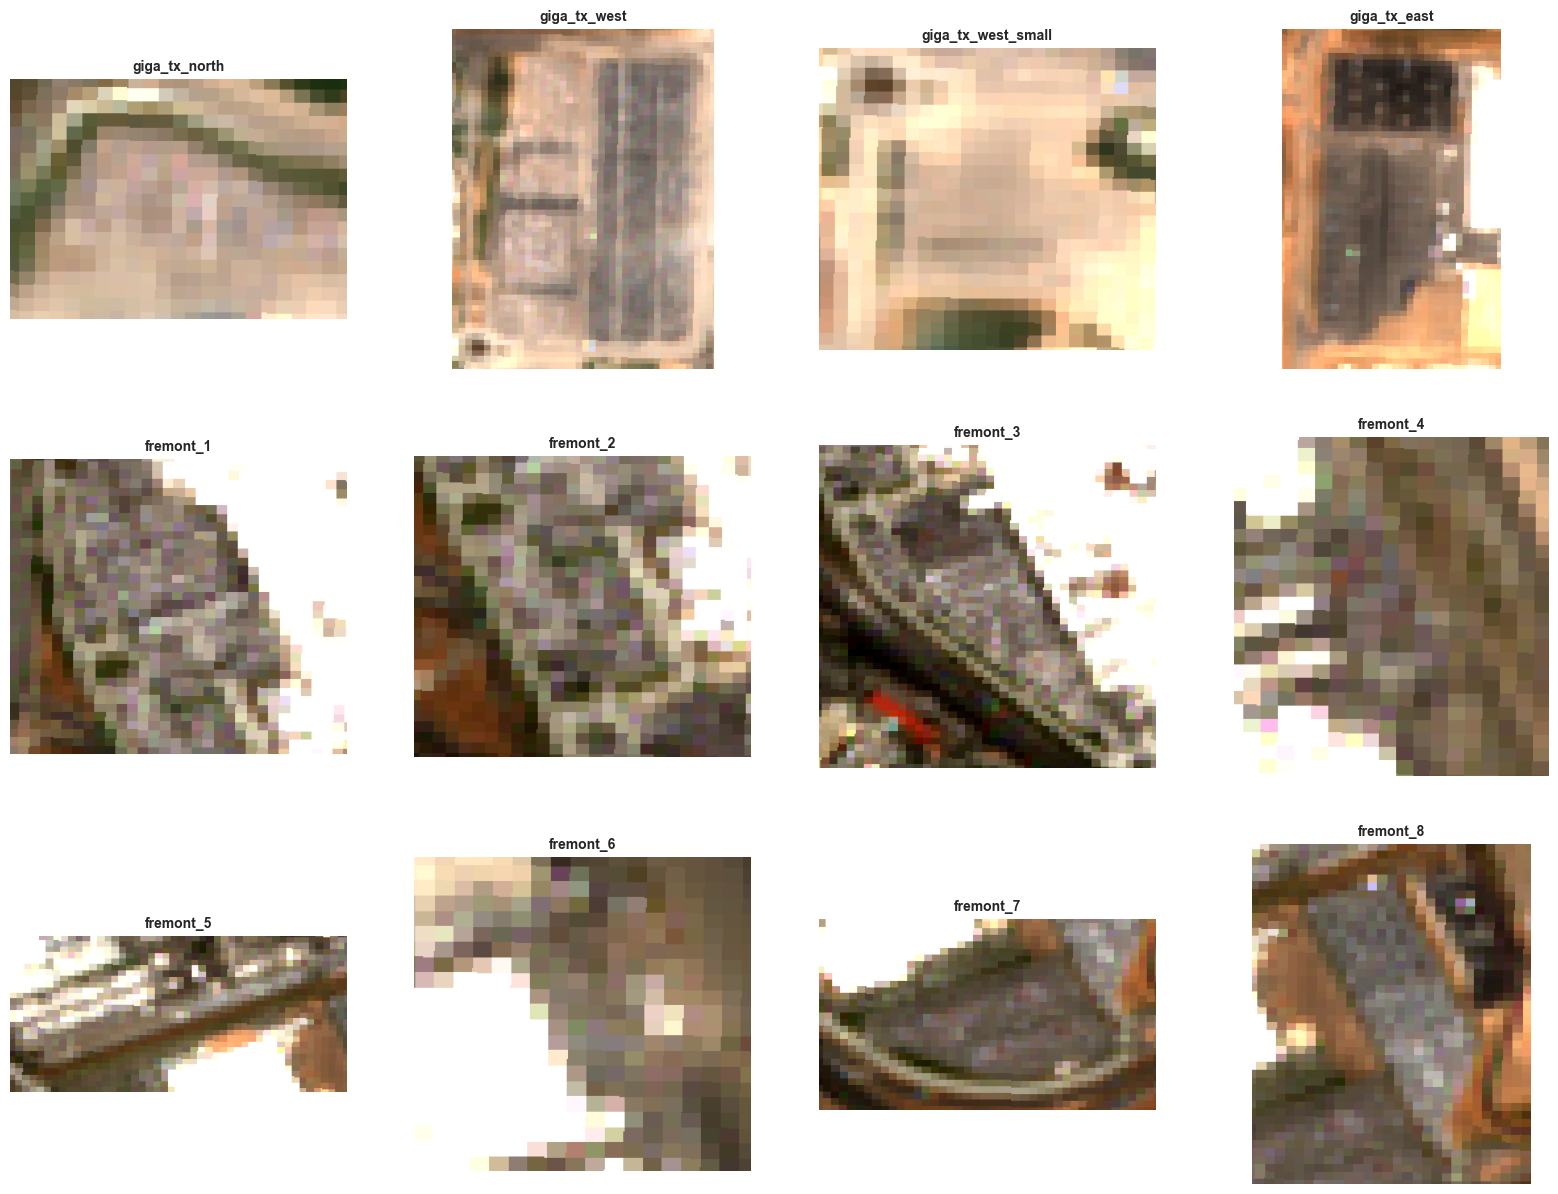

In [75]:
import requests
from PIL import Image
from io import BytesIO

DEMO_START = '2024-06-01'
DEMO_END = '2024-07-01'

# Show EVERY parking lot polygon — exactly what our code analyzes
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, (name, geom) in enumerate(SITES.items()):
    # Small buffer (50m) — tight view of just the parking lot
    tight_bounds = geom.bounds().buffer(50).bounds()
    
    comp = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(geom)
        .filterDate(DEMO_START, DEMO_END)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .median()
    )
    
    thumb_url = comp.getThumbURL({
        'bands': ['B4', 'B3', 'B2'],
        'min': 400,
        'max': 3000,
        'region': tight_bounds,
        'dimensions': 256,
        'format': 'png',
    })
    
    response = requests.get(thumb_url)
    img = Image.open(BytesIO(response.content))
    
    axes[i].imshow(img)
    axes[i].set_title(f'{name}', fontsize=10, fontweight='bold')
    axes[i].axis('off')

# Hide unused subplot
for j in range(len(SITES), len(axes)):
    axes[j].axis('off')

plt.suptitle('Sentinel-2 RGB — Each parking lot polygon (50m buffer) — June 2024\nThis is EXACTLY what our algorithm sees per site', fontsize=13)
plt.tight_layout()
plt.show()

## 4. Generate Monthly Time Series

We loop month-by-month from 2022-01 to present and query each site.  
This takes a few minutes (one GEE API call per site per month).

In [57]:
START = datetime(2022, 1, 1)
END = datetime(2026, 2, 1)  # adjust to current month

# Build list of monthly periods
periods = []
current = START
while current < END:
    next_month = current + relativedelta(months=1)
    periods.append((current.strftime('%Y-%m-%d'), next_month.strftime('%Y-%m-%d')))
    current = next_month

print(f'{len(periods)} monthly periods: {periods[0][0]} → {periods[-1][1]}')

49 monthly periods: 2022-01-01 → 2026-02-01


In [58]:
# ── FULL RUN: all months ──
TEST_MONTHS = len(periods)

all_records = []

for i, (start, end) in enumerate(periods[:TEST_MONTHS]):
    for site_name, geometry in SITES.items():
        try:
            metrics = compute_fill_metrics(geometry, start, end)
            metrics['date'] = start
            metrics['site'] = site_name
            all_records.append(metrics)
        except Exception as e:
            print(f'  Error {site_name} {start}: {e}')
    if (i + 1) % 6 == 0 or i == 0:
        print(f'  [{i+1}/{TEST_MONTHS}] {start} — done')

df_long = pd.DataFrame(all_records)
df_long['date'] = pd.to_datetime(df_long['date'])

# Convert metrics to numeric
metric_cols = ['brightness_mean', 'brightness_std', 'bright_pixel_frac', 'nir_red_ratio', 'color_std']
for col in metric_cols:
    df_long[col] = pd.to_numeric(df_long[col], errors='coerce')

print(f'\nShape: {df_long.shape}')
print(f'\nNon-null counts per metric:')
print(df_long[metric_cols].notna().sum())
print(f'\nSample:')
df_long.head(20)

  [1/49] 2022-01-01 — done
  [6/49] 2022-06-01 — done
  [12/49] 2022-12-01 — done
  [18/49] 2023-06-01 — done
  [24/49] 2023-12-01 — done
  [30/49] 2024-06-01 — done
  [36/49] 2024-12-01 — done
  [42/49] 2025-06-01 — done
  [48/49] 2025-12-01 — done

Shape: (784, 8)

Non-null counts per metric:
brightness_mean      700
brightness_std       700
bright_pixel_frac    700
nir_red_ratio        700
color_std            700
dtype: int64

Sample:


,brightness_mean,brightness_std,bright_pixel_frac,nir_red_ratio,color_std,n_images,date,site
0,1672.597792,323.613767,0.666951,1.215962,207.378097,6.0,2022-01-01,giga_tx_north
1,2721.202058,378.911282,0.998734,1.183319,558.058407,6.0,2022-01-01,giga_tx_west
2,2522.244256,361.741533,1.000000,1.212166,518.661893,6.0,2022-01-01,giga_tx_west_small
3,1469.836437,732.215919,0.443317,1.645182,448.508551,6.0,2022-01-01,giga_tx_east
4,1325.047684,251.701594,0.209122,1.163057,121.736800,3.0,2022-01-01,fremont_1
5,1340.719408,285.504901,0.298743,1.285855,116.885711,3.0,2022-01-01,fremont_2
6,1536.978196,467.794371,0.451648,1.153514,142.360184,3.0,2022-01-01,fremont_3
7,969.823777,171.761245,0.000000,2.030848,167.927390,3.0,2022-01-01,fremont_4
8,1459.204413,325.399444,0.415955,1.203625,139.798283,3.0,2022-01-01,fremont_5
9,1375.900471,157.870732,0.161001,1.093892,152.165578,3.0,2022-01-01,fremont_6


In [62]:
# Pivot to wide format for each metric (for easier plotting & CSV export)
metric_cols = ['brightness_mean', 'brightness_std', 'bright_pixel_frac', 'nir_red_ratio', 'color_std']

dfs_wide = {}
for metric in metric_cols:
    wide = df_long.pivot(index='date', columns='site', values=metric)
    wide.columns = [f'{col}_{metric}' for col in wide.columns]
    dfs_wide[metric] = wide

# Merge all into one wide dataframe
df = pd.concat(dfs_wide.values(), axis=1)

# Also add n_images per site
n_imgs = df_long.pivot(index='date', columns='site', values='n_images')
n_imgs.columns = [f'{col}_n_imgs' for col in n_imgs.columns]
df = df.join(n_imgs)

print(f'Wide dataset: {df.shape}')
df.head()

Wide dataset: (49, 96)


,berlin_1_brightness_mean,berlin_2_brightness_mean,berlin_3_brightness_mean,berlin_4_brightness_mean,fremont_1_brightness_mean,fremont_2_brightness_mean,fremont_3_brightness_mean,fremont_4_brightness_mean,fremont_5_brightness_mean,fremont_6_brightness_mean,...,fremont_3_n_imgs,fremont_4_n_imgs,fremont_5_n_imgs,fremont_6_n_imgs,fremont_7_n_imgs,fremont_8_n_imgs,giga_tx_east_n_imgs,giga_tx_north_n_imgs,giga_tx_west_n_imgs,giga_tx_west_small_n_imgs
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,937.341185,2384.769204,1436.624620,750.623517,1325.047684,1340.719408,1536.978196,969.823777,1459.204413,1375.900471,...,3.0,3.0,3.0,3.0,3.0,3.0,6.0,6.0,6.0,6.0
2022-02-01,NaN,NaN,NaN,NaN,1477.833733,1403.061234,1413.733016,1712.115757,1428.178580,1228.907065,...,5.0,5.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0
2022-03-01,1351.513547,2868.730961,1904.833222,920.749548,1485.100607,1384.182942,1453.787132,1430.596840,1400.291684,1304.263612,...,2.0,2.0,2.0,2.0,2.0,2.0,7.0,7.0,7.0,7.0
2022-04-01,1258.534483,2028.181547,2185.249921,1935.778742,1533.128512,1411.205057,1462.364148,1705.901389,1442.511710,1434.883703,...,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0
2022-05-01,NaN,NaN,NaN,NaN,1684.568192,1620.057843,1615.040364,1728.150421,1691.293296,3226.909380,...,3.0,3.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0


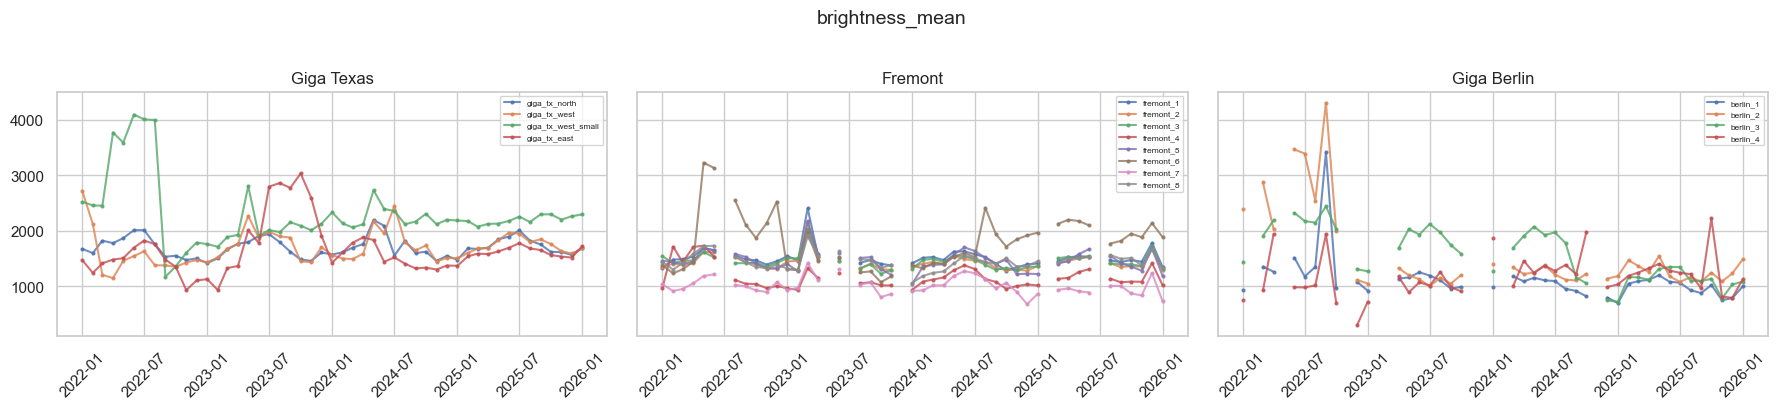

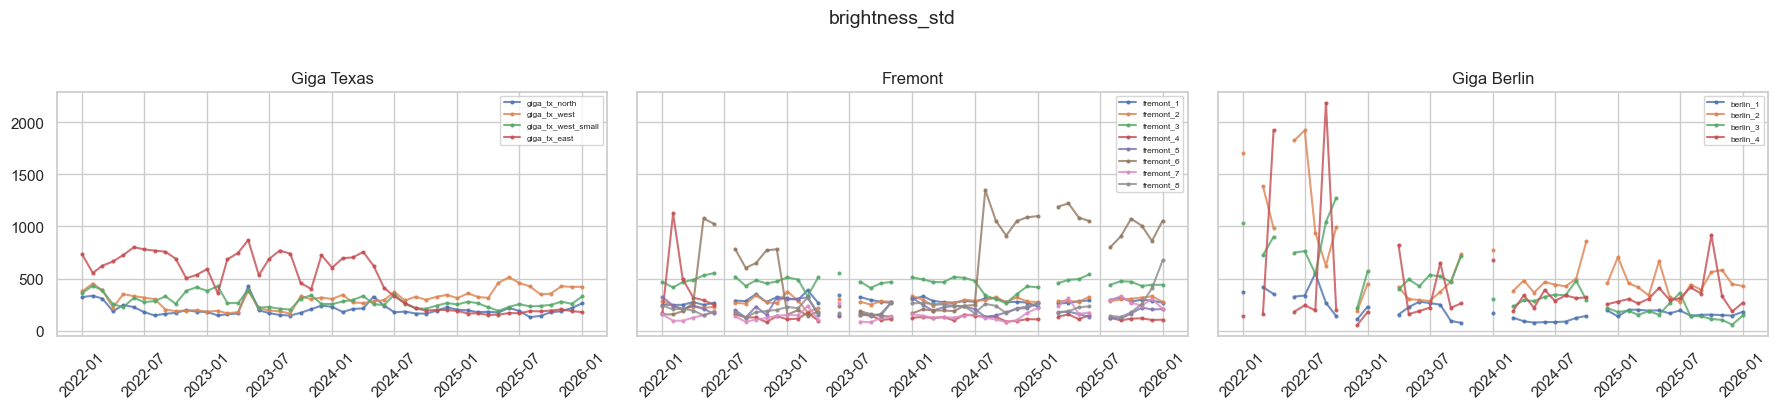

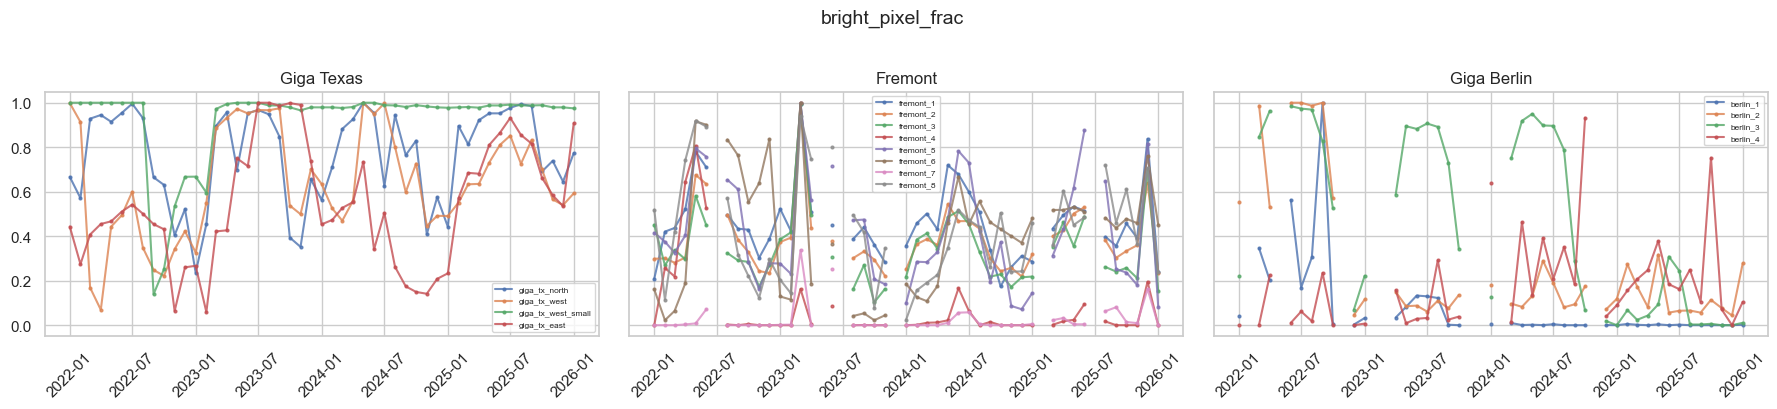

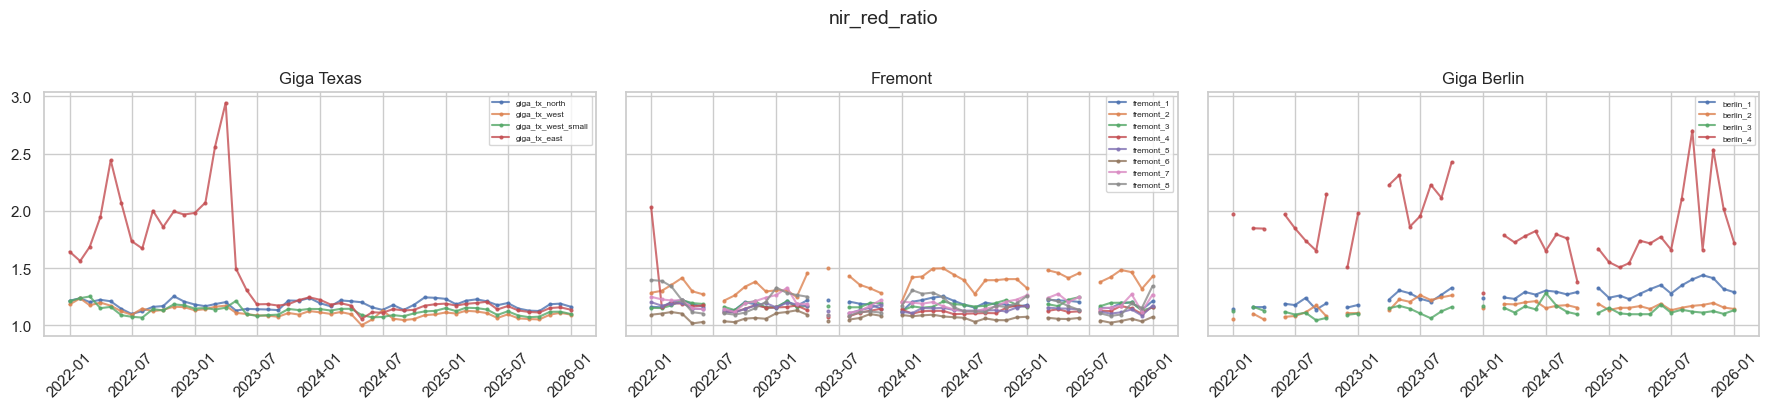

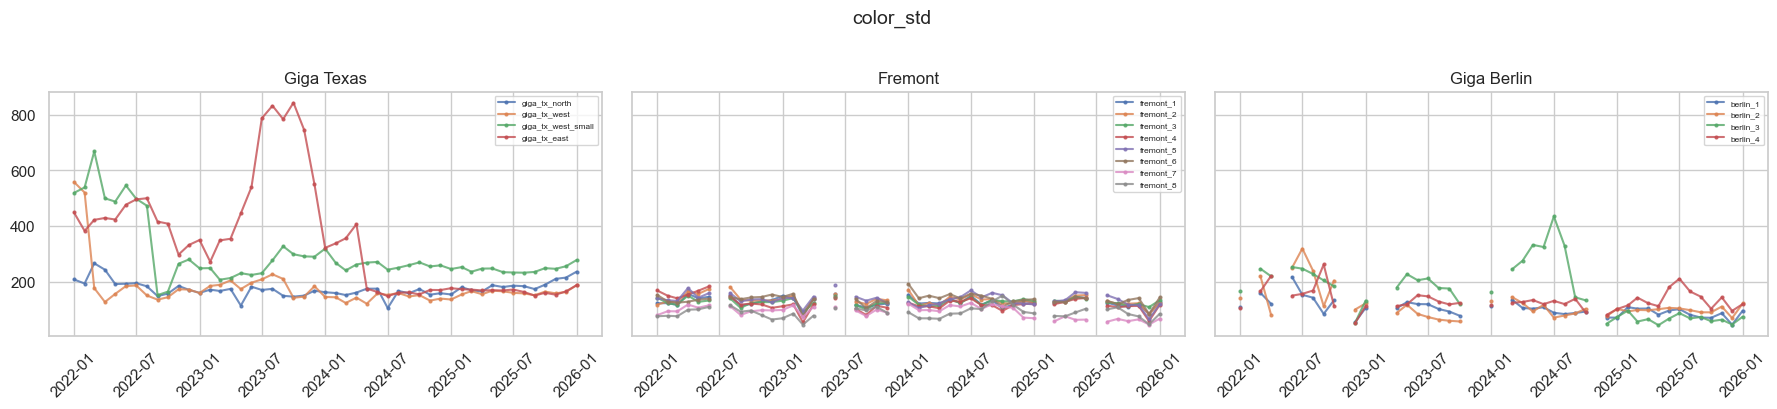

In [63]:
# ── Plot each metric across all sites ──
site_names = df_long['site'].unique()

# Group sites by factory for cleaner plotting
factory_groups = {
    'Giga Texas': [s for s in site_names if s.startswith('giga_tx')],
    'Fremont': [s for s in site_names if s.startswith('fremont')],
    'Giga Berlin': [s for s in site_names if s.startswith('berlin')],
}

for metric in metric_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    fig.suptitle(f'{metric}', fontsize=14, y=1.02)
    
    for ax, (factory, sites) in zip(axes, factory_groups.items()):
        for site in sites:
            site_data = df_long[df_long['site'] == site].sort_values('date')
            ax.plot(site_data['date'], site_data[metric],
                    marker='o', markersize=2, label=site, alpha=0.8)
        ax.set_title(factory)
        ax.legend(fontsize=6)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [64]:
# ── Per-site summary statistics ──
summary = df_long.groupby('site')[metric_cols].agg(['mean', 'std', 'min', 'max']).round(2)
print('Per-site summary:')
summary

Per-site summary:


brightness_mean                           brightness_std  \
                              mean     std      min      max           mean   
site                                                                          
berlin_1                   1109.90  411.01   692.60  3414.84         196.82   
berlin_2                   1546.77  762.42   997.08  4307.51         627.85   
berlin_3                   1553.59  477.58   718.23  2438.29         417.67   
berlin_4                   1177.03  387.76   294.46  2219.49         399.89   
fremont_1                  1502.89  171.35  1274.48  2403.88         288.47   
fremont_2                  1428.62  146.49  1277.74  2154.13         280.12   
fremont_3                  1447.03  134.55  1219.85  2025.78         458.72   
fremont_4                  1163.94  210.36   929.68  1728.15         169.20   
fremont_5                  1451.96  191.50  1041.62  2171.74         207.54   
fremont_6                  1793.48  493.48  1070.13  3226.91         610.81   
fremont_7                  1004.46  154.64   673.96  1413.17         165.16   
fremont_8                  1444.79  151.87  1062.79  1897.50         222.56   
giga_tx_east               1647.45  460.51   927.30  3033.02         474.02   
giga_tx_north              1699.55  181.41  1415.18  2195.01         204.73   
giga_tx_west               1692.97  302.64  1144.64  2721.20         310.80   
giga_tx_west_small         2300.69  615.89  1166.44  4094.63         284.63   

                                            bright_pixel_frac              \
                       std     min      max              mean   std   min   
site                                                                        
berlin_1            103.46   76.60   550.59              0.08  0.19  0.00   
berlin_2            417.94  186.93  1921.04              0.27  0.31  0.04   
berlin_3            290.74   59.39  1274.26              0.46  0.40  0.00   
berlin_4            423.05   54.16  2185.44              0.18  0.21  0.00   
fremont_1            30.13  231.56   388.71              0.46  0.17  0.17   
fremont_2            38.02  177.65   376.34              0.39  0.15  0.22   
fremont_3            63.43  265.92   558.21              0.34  0.16  0.10   
fremont_4           165.97   83.66  1125.63              0.08  0.18  0.00   
fremont_5            58.74  118.38   325.40              0.42  0.24  0.07   
fremont_6           421.03  134.81  1349.43              0.42  0.27  0.02   
fremont_7            67.51   81.83   332.10              0.03  0.07  0.00   
fremont_8            88.86  126.95   674.43              0.43  0.24  0.02   
giga_tx_east        246.57  153.12   869.93              0.55  0.27  0.06   
giga_tx_north        57.45  131.59   428.22              0.76  0.21  0.24   
giga_tx_west         88.98  166.01   512.81              0.64  0.24  0.07   
giga_tx_west_small   62.71  191.69   433.39              0.92  0.18  0.14   

                         nir_red_ratio                   color_std          \
                     max          mean   std   min   max      mean     std   
site                                                                         
berlin_1            1.00          1.26  0.07  1.14  1.44    102.43   30.86   
berlin_2            1.00          1.16  0.05  1.05  1.26    115.15   55.93   
berlin_3            0.98          1.13  0.04  1.05  1.28    162.63   97.15   
berlin_4            0.93          1.86  0.30  1.29  2.70    132.91   38.14   
fremont_1           0.99          1.19  0.03  1.12  1.25    126.31   17.11   
fremont_2           1.00          1.37  0.08  1.21  1.51    133.44   19.56   
fremont_3           0.99          1.18  0.03  1.13  1.25    126.07   13.39   
fremont_4           0.81          1.16  0.14  1.07  2.03    120.30   24.68   
fremont_5           1.00          1.15  0.03  1.09  1.20    135.42   21.75   
fremont_6           1.00          1.07  0.03  1.02  1.13    135.60   18.84   
fremont_7           0.34          1.19 

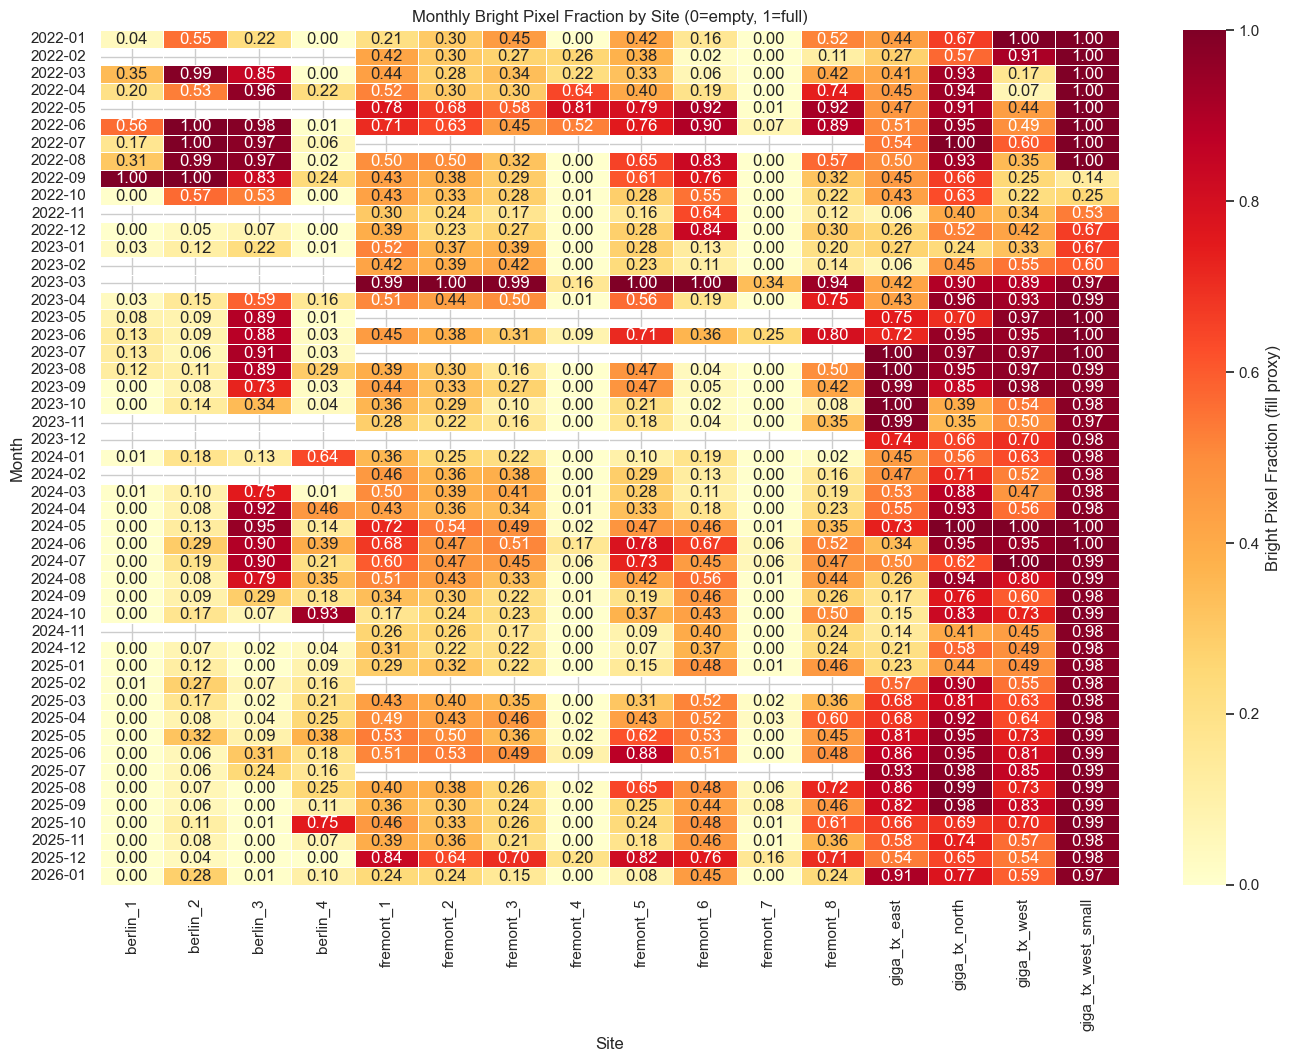

In [65]:
# ── Heatmap: bright_pixel_frac over time per site (most interpretable metric) ──
heatmap_data = df_long.pivot(index='date', columns='site', values='bright_pixel_frac')
heatmap_data.index = heatmap_data.index.strftime('%Y-%m')

fig, ax = plt.subplots(figsize=(14, max(8, len(heatmap_data) * 0.22)))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd',
            ax=ax, cbar_kws={'label': 'Bright Pixel Fraction (fill proxy)'},
            linewidths=0.5)
ax.set_title('Monthly Bright Pixel Fraction by Site (0=empty, 1=full)')
ax.set_ylabel('Month')
ax.set_xlabel('Site')
plt.tight_layout()
plt.show()

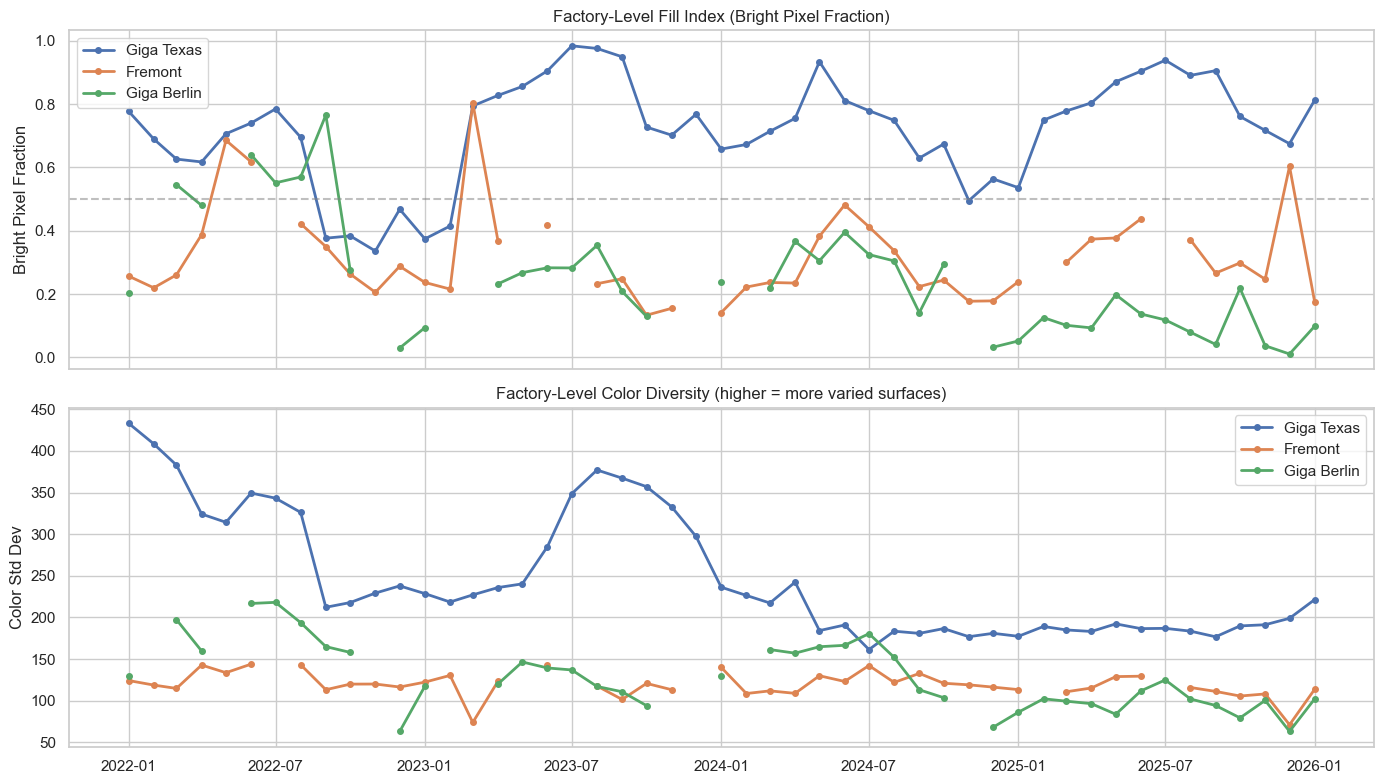

In [66]:
# ── Aggregate factory-level fill index (mean across lots per factory) ──
df_long['factory'] = df_long['site'].apply(
    lambda s: 'Giga Texas' if s.startswith('giga_tx')
    else 'Fremont' if s.startswith('fremont')
    else 'Giga Berlin'
)

factory_monthly = df_long.groupby(['date', 'factory'])[metric_cols].mean().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Bright pixel fraction by factory
for factory in ['Giga Texas', 'Fremont', 'Giga Berlin']:
    data = factory_monthly[factory_monthly['factory'] == factory].sort_values('date')
    axes[0].plot(data['date'], data['bright_pixel_frac'],
                 marker='o', markersize=4, label=factory, linewidth=2)
axes[0].set_ylabel('Bright Pixel Fraction')
axes[0].set_title('Factory-Level Fill Index (Bright Pixel Fraction)')
axes[0].legend()
axes[0].axhline(0.5, ls='--', color='gray', alpha=0.5)

# Color std by factory
for factory in ['Giga Texas', 'Fremont', 'Giga Berlin']:
    data = factory_monthly[factory_monthly['factory'] == factory].sort_values('date')
    axes[1].plot(data['date'], data['color_std'],
                 marker='o', markersize=4, label=factory, linewidth=2)
axes[1].set_ylabel('Color Std Dev')
axes[1].set_title('Factory-Level Color Diversity (higher = more varied surfaces)')
axes[1].legend()

plt.tight_layout()
plt.show()

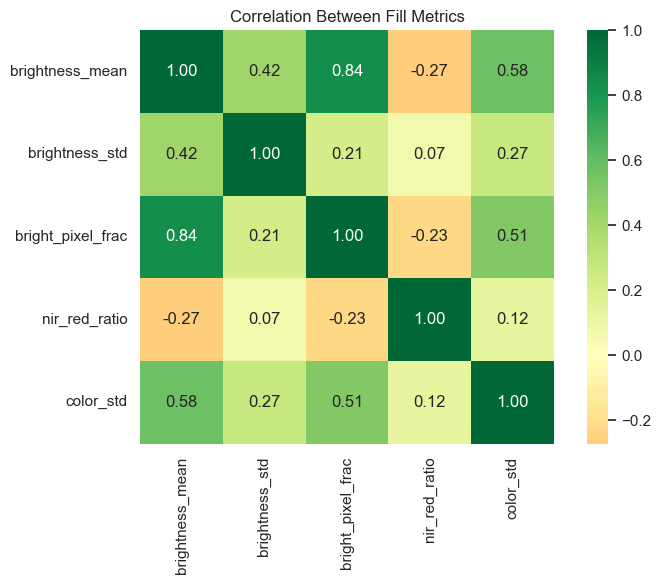

In [67]:
# ── Correlation between metrics ──
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_long[metric_cols].corr(), annot=True, fmt='.2f',
            cmap='RdYlGn', center=0, ax=ax, square=True)
ax.set_title('Correlation Between Fill Metrics')
plt.tight_layout()
plt.show()

In [ ]:
from src.helpers import DATA_RAW, DATA_PROCESSED

# ── Save raw outputs ──
df_long.to_csv(DATA_RAW / 'tesla_satellite_fill_metrics_long.csv', index=False)
df.to_csv(DATA_RAW / 'tesla_satellite_fill_metrics_wide.csv')
print(f'Saved raw long format: {df_long.shape}')
print(f'Saved raw wide format: {df.shape}')

## 8. Cleaned Trading-Ready Dataset

We keep only **useful metrics** (`bright_pixel_frac`, `brightness_std`, `color_std`) and aggregate per factory into a compact monthly time series ready to merge with TSLA price data.

**Dropped (noisy/redundant):**
- `brightness_mean` → redundant with `bright_pixel_frac`
- `nir_red_ratio` → too noisy, dominated by terrain not cars

**Sites dropped earlier:**
- `giga_tx_west_small` → always full (no variation)
- `giga_tx_east` → vegetation contamination (NIR ratio 1.45–2.94)
- `fremont_4`, `fremont_7` → always empty (wrong polygons)
- `berlin_4` → forest/field, not parking (NIR ratio 1.86)

In [69]:
# ── Build factory-level aggregated trading features ──
USEFUL_METRICS = ['bright_pixel_frac', 'brightness_std', 'color_std']

# Add factory label
df_long['factory'] = df_long['site'].apply(
    lambda s: 'giga_tx' if s.startswith('giga_tx')
    else 'fremont' if s.startswith('fremont')
    else 'berlin'
)

# Aggregate: mean across lots per factory per month
factory_agg = df_long.groupby(['date', 'factory'])[USEFUL_METRICS].mean()

# Pivot to wide: one column per factory × metric
trading_df = factory_agg.unstack('factory')
trading_df.columns = [f'sat_{factory}_{metric}' for metric, factory in trading_df.columns]

# Add month-over-month change (the actual trading signal)
for col in trading_df.columns:
    trading_df[f'{col}_mom_change'] = trading_df[col].diff()

# Add global fill index (average across all factories)
fill_cols = [c for c in trading_df.columns if 'bright_pixel_frac' in c and 'mom' not in c]
trading_df['sat_global_fill'] = trading_df[fill_cols].mean(axis=1)
trading_df['sat_global_fill_mom'] = trading_df['sat_global_fill'].diff()

print(f'Trading dataset: {trading_df.shape}')
print(f'Columns: {list(trading_df.columns)}')
print(f'\nNon-null counts:')
print(trading_df.notna().sum())
trading_df.head(10)

Trading dataset: (49, 20)
Columns: ['sat_berlin_bright_pixel_frac', 'sat_fremont_bright_pixel_frac', 'sat_giga_tx_bright_pixel_frac', 'sat_berlin_brightness_std', 'sat_fremont_brightness_std', 'sat_giga_tx_brightness_std', 'sat_berlin_color_std', 'sat_fremont_color_std', 'sat_giga_tx_color_std', 'sat_berlin_bright_pixel_frac_mom_change', 'sat_fremont_bright_pixel_frac_mom_change', 'sat_giga_tx_bright_pixel_frac_mom_change', 'sat_berlin_brightness_std_mom_change', 'sat_fremont_brightness_std_mom_change', 'sat_giga_tx_brightness_std_mom_change', 'sat_berlin_color_std_mom_change', 'sat_fremont_color_std_mom_change', 'sat_giga_tx_color_std_mom_change', 'sat_global_fill', 'sat_global_fill_mom']

Non-null counts:
sat_berlin_bright_pixel_frac                40
sat_fremont_bright_pixel_frac               43
sat_giga_tx_bright_pixel_frac               49
sat_berlin_brightness_std                   40
sat_fremont_brightness_std                  43
sat_giga_tx_brightness_std                  49
s

,sat_berlin_bright_pixel_frac,sat_fremont_bright_pixel_frac,sat_giga_tx_bright_pixel_frac,sat_berlin_brightness_std,sat_fremont_brightness_std,sat_giga_tx_brightness_std,sat_berlin_color_std,sat_fremont_color_std,sat_giga_tx_color_std,sat_berlin_bright_pixel_frac_mom_change,sat_fremont_bright_pixel_frac_mom_change,sat_giga_tx_bright_pixel_frac_mom_change,sat_berlin_brightness_std_mom_change,sat_fremont_brightness_std_mom_change,sat_giga_tx_brightness_std_mom_change,sat_berlin_color_std_mom_change,sat_fremont_color_std_mom_change,sat_giga_tx_color_std_mom_change,sat_global_fill,sat_global_fill_mom
date,,,,,,,,,,,,,,,,,,,,
2022-01-01,0.204067,0.256960,0.777251,812.933130,257.344101,449.120625,129.891156,124.336038,433.151737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.412759,NaN
2022-02-01,NaN,0.219866,0.689637,NaN,341.203892,444.195683,NaN,118.895889,408.375178,NaN,-0.037094,-0.087614,NaN,83.859791,-4.924942,NaN,-5.440149,-24.776559,0.454752,0.041992
2022-03-01,0.545487,0.260675,0.626142,673.227700,266.038863,426.674184,197.452317,114.861594,382.869634,NaN,0.040809,-0.063495,NaN,-75.165029,-17.521500,NaN,-4.034295,-25.505544,0.477435,0.022683
2022-04-01,0.479858,0.387706,0.617175,1039.753061,268.519069,332.287621,159.783859,142.918139,324.156426,-0.065628,0.127031,-0.008967,366.525361,2.480206,-94.386562,-37.668458,28.056545,-58.713208,0.494913,0.017479
2022-05-01,NaN,0.685295,0.706127,NaN,359.555369,388.739957,NaN,133.729944,314.234517,NaN,0.297588,0.088952,NaN,91.036300,56.452335,NaN,-9.188195,-9.921910,0.695711,0.200798
2022-06-01,0.639675,0.617410,0.740002,771.857359,357.505482,419.089501,216.824714,144.036859,349.353116,NaN,-0.067884,0.033875,NaN,-2.049887,30.349544,NaN,10.306915,35.118599,0.665696,-0.030015
2022-07-01,0.551153,NaN,0.784426,816.770721,NaN,388.681576,218.183774,NaN,343.203166,-0.088522,NaN,0.044424,44.913362,NaN,-30.407925,1.359060,NaN,-6.149950,0.667790,0.002094
2022-08-01,0.569699,0.422248,0.695023,558.838696,317.722826,375.987300,193.812204,143.322779,326.154119,0.018545,NaN,-0.089403,-257.932025,NaN,-12.694276,-24.371571,NaN,-17.049047,0.562323,-0.105467
2022-09-01,0.765292,0.349936,0.376511,1030.592253,256.000283,364.293689,165.057390,113.291741,212.240999,0.195593,-0.072311,-0.318512,471.753557,-61.722543,-11.693611,-28.754813,-30.031039,-113.913120,0.497246,-0.065077


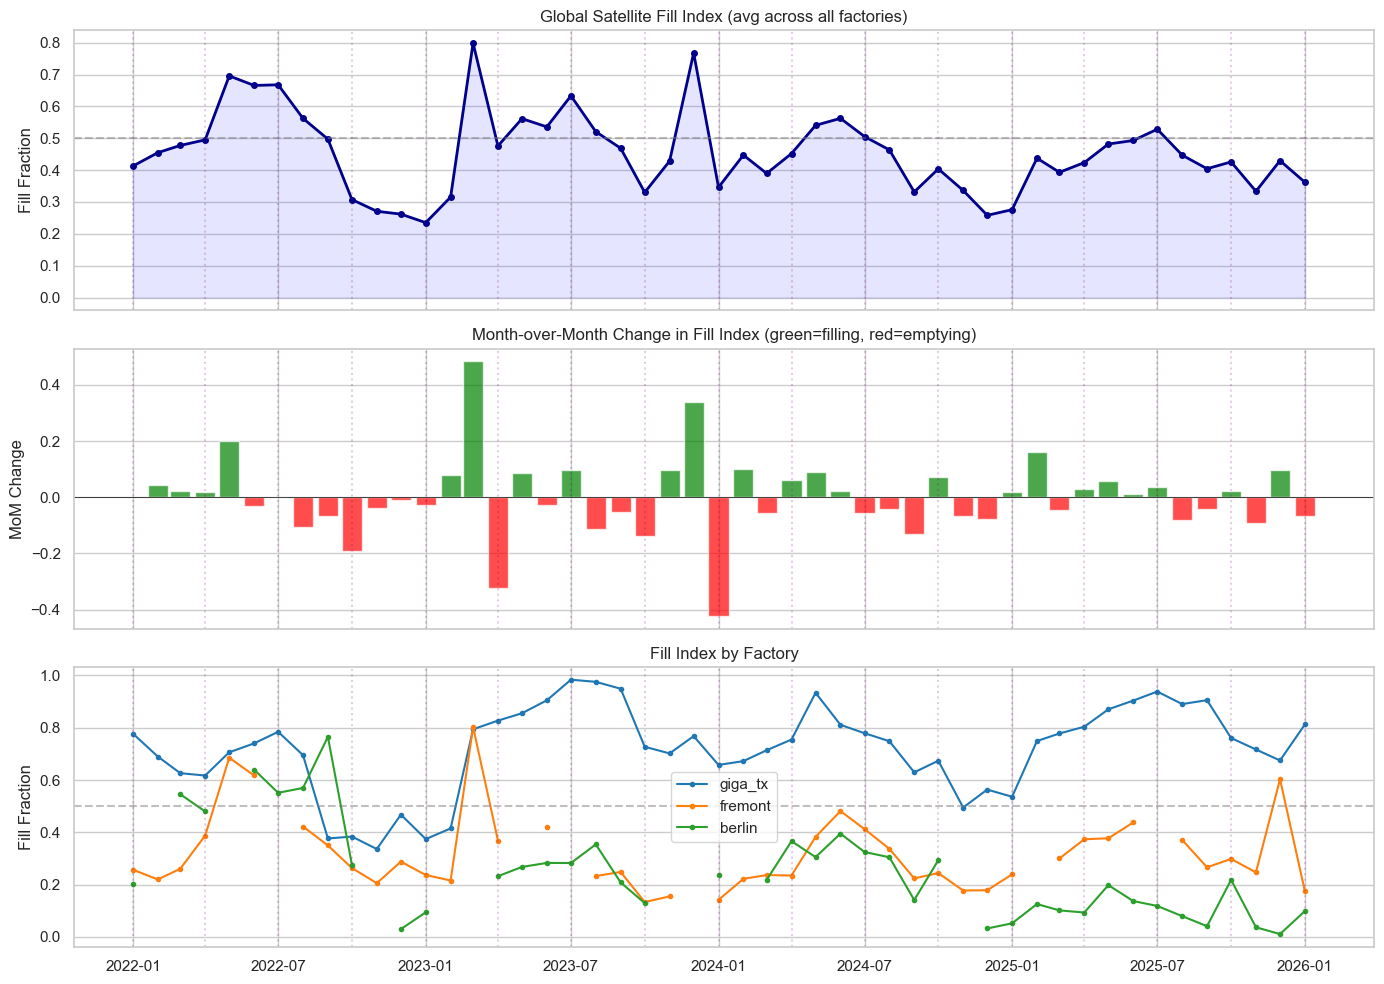

Purple dotted lines = approximate quarterly delivery report months


In [70]:
# ── Visualize the key trading signals ──
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1. Global fill index
axes[0].plot(trading_df.index, trading_df['sat_global_fill'],
             marker='o', markersize=4, linewidth=2, color='darkblue')
axes[0].axhline(0.5, ls='--', color='gray', alpha=0.5)
axes[0].set_ylabel('Fill Fraction')
axes[0].set_title('Global Satellite Fill Index (avg across all factories)')
axes[0].fill_between(trading_df.index, 0, trading_df['sat_global_fill'],
                     alpha=0.1, color='blue')

# 2. Month-over-month change (the actual signal)
colors = ['green' if v > 0 else 'red' for v in trading_df['sat_global_fill_mom'].fillna(0)]
axes[1].bar(trading_df.index, trading_df['sat_global_fill_mom'], width=25,
            color=colors, alpha=0.7)
axes[1].axhline(0, ls='-', color='black', linewidth=0.5)
axes[1].set_ylabel('MoM Change')
axes[1].set_title('Month-over-Month Change in Fill Index (green=filling, red=emptying)')

# 3. Per-factory fill
for factory, color in [('giga_tx', 'tab:blue'), ('fremont', 'tab:orange'), ('berlin', 'tab:green')]:
    col = f'sat_{factory}_bright_pixel_frac'
    if col in trading_df.columns:
        axes[2].plot(trading_df.index, trading_df[col],
                     marker='o', markersize=3, label=factory, color=color, linewidth=1.5)
axes[2].set_ylabel('Fill Fraction')
axes[2].set_title('Fill Index by Factory')
axes[2].legend()
axes[2].axhline(0.5, ls='--', color='gray', alpha=0.5)

# Mark quarterly delivery report months (Jan, Apr, Jul, Oct)
for ax in axes:
    for year in range(2022, 2027):
        for month in [1, 4, 7, 10]:
            date = pd.Timestamp(year, month, 1)
            if date >= trading_df.index.min() and date <= trading_df.index.max():
                ax.axvline(date, ls=':', color='purple', alpha=0.2)

plt.tight_layout()
plt.show()
print('Purple dotted lines = approximate quarterly delivery report months')

In [ ]:
# ── Save trading-ready dataset ──
trading_df.to_csv(DATA_PROCESSED / 'satellite_trading_features.csv')
print(f'Saved trading features: {trading_df.shape}')
print(f'Path: {DATA_PROCESSED / "satellite_trading_features.csv"}')
print(f'\nThis can be merged with TSLA price data in notebook 01 using:')
print('  master = master.join(trading_df, how="left")')

## 7. Interpretation & Next Steps

### What to look for
- **Spikes in brightness** before quarterly delivery reports → possible inventory build-up
- **Drops after delivery dates** → lots emptying as cars ship out
- **Seasonal patterns** — brightness also affected by sun angle (higher in summer), so consider normalizing by month or using relative changes

### Caveats
- **Sun angle & season** affect brightness even for identical lot conditions — a simple fix is to look at month-over-month *change* rather than absolute values
- **Cloud cover** may leave some months with few usable images (check `_n_imgs` columns)
- **Polygon accuracy** matters a lot — refine using recent Google Earth imagery to ensure you're covering actual car storage, not roads or buildings

### Improvement ideas
1. **Threshold-based fill ratio**: count fraction of pixels above a brightness threshold (e.g., >1500) instead of mean — more robust to mixed surfaces
2. **NIR band (B8)**: cars reflect differently in near-infrared vs asphalt — `B8 / B4` ratio could improve discrimination
3. **Bi-weekly frequency**: use 15-day windows instead of monthly for more granular signal
4. **Normalize by empty-lot baseline**: compute brightness of a known-empty area nearby and use the ratio
5. **Cloud-free pixel count**: report what % of the polygon had valid data per composite
6. **Image export**: export RGB composites as GeoTIFF for visual verification